In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

2.0.0
3.1


In [3]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time



In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(2) ##!! changed this from problem formulation 3 to 2

In [5]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [6]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x126d89f80>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x126d89f80>)
ScalarOutcome('RfR Investment Costs', variable_name=('RfR Total Costs',), function=<function sum_over at 0x126d89f80>)
ScalarOutcome('Evacuation Costs', variable_name=('Expected Evacuation Costs',), function=<function sum_over at 0x126d89f80>)
ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths'), function=<function sum_over at 0x126

In [9]:
# defining specific policies
# for example, policy 1 is about extra protection in upper boundary
# policy 2 is about extra protection in lower boundary
# policy 3 is extra protection in random locations


def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies = [
    Policy(
        "NaN",
        **dict(
            get_do_nothing_dict(),
            **{}
        )
    ),
    Policy(
        "RfR",
        **dict(
            get_do_nothing_dict(),
            **{"0_RfR 0": 1, "1_RfR 0": 1, "2_RfR 0": 1, "3_RfR 0": 1, "4_RfR 0": 1}
        )
    ),
    Policy(
        "Dike",
        **dict(
            get_do_nothing_dict(),
            **{ "A.1_DikeIncrease 0": 10, "A.2_DikeIncrease 0": 10, "A.3_DikeIncrease 0": 10, "A.4_DikeIncrease 0": 10, "A.5_DikeIncrease 0": 10}
        )
    ),
    Policy(
        "Evacuation",
        **dict(
            get_do_nothing_dict(),
            **{ "EWS_DaysToThreat": 4}
        )
    ),
    Policy(
        "FirstDebate", #based on outcome of 1.5 debate
        **dict(
            get_do_nothing_dict(),
            **{ "0_RfR 0": 1, "A.3_DikeIncrease 0": 10, "3_RfR 0": 1, "A.5_DikeIncrease 0": 10}
        )
    ),
]

In [7]:
############################################
# defining specific policies
# for RWS
# policy 2 is about extra protection in lower boundary
# policy 3 is extra protection in random locations


def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies = [
    Policy(
        "NaN",
        **dict(
            get_do_nothing_dict(),
            **{}
        )
    ),
    Policy(
        "RfR",
        **dict(
            get_do_nothing_dict(),
            **{"0_RfR 0": 1, "1_RfR 0": 1, "2_RfR 0": 1, "3_RfR 0": 1, "4_RfR 0": 1}
        )
    ),
    Policy(
        "DH",
        **dict(
            get_do_nothing_dict(),
            **{ "A.1_DikeIncrease 0": 10, "A.2_DikeIncrease 0": 10, "A.3_DikeIncrease 0": 10, "A.4_DikeIncrease 0": 10, "A.5_DikeIncrease 0": 10}
        )
    ),
    Policy(
        "EWS",
        **dict(
            get_do_nothing_dict(),
            **{ "EWS_DaysToThreat": 4}
        )
    ),
    Policy(
        "1RfR_3DH_4RfR_5DH", #based on outcome of 1.5 debate
        **dict(
            get_do_nothing_dict(),
            **{ "0_RfR 0": 1, "A.3_DikeIncrease 0": 10, "3_RfR 0": 1, "A.5_DikeIncrease 0": 10}
        )
    ),
    Policy(
        "1RfR_3DH_5DH", #based on outcome of 1.5 debate
        **dict(
            get_do_nothing_dict(),
            **{ "0_RfR 0": 1, "A.3_DikeIncrease 0": 10, "A.5_DikeIncrease 0": 10}
        )
    ),
    Policy(
        "1RfR_3DH_5DH+EWS", #based on outcome of 1.5 debate
        **dict(
            get_do_nothing_dict(),
            **{ "0_RfR 0": 1, "A.3_DikeIncrease 0": 10, "A.5_DikeIncrease 0": 10, "EWS_DaysToThreat": 4}
        )
    ),
    Policy(
        "1RfR_3DH_4RfR_5DH-5dm", #based on outcome of 1.5 debate
        **dict(
            get_do_nothing_dict(),
            **{ "0_RfR 0": 1, "A.3_DikeIncrease 0": 5, "3_RfR 0": 1, "A.5_DikeIncrease 0": 5}
        )
    ),
]

In [7]:
############################################
# defining specific policies
# for RWS
# policy 2 is about extra protection in lower boundary
# policy 3 is extra protection in random locations


def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies = [
    Policy(
        "1RfR_3DH", #based on outcome of 1.5 debate
        **dict(
            get_do_nothing_dict(),
            **{ "0_RfR 0": 1, "A.3_DikeIncrease 0": 10}
        )
    ),
    Policy(
        "1RfR_5DH", #based on outcome of 1.5 debate
        **dict(
            get_do_nothing_dict(),
            **{ "0_RfR 0": 1, "A.5_DikeIncrease 0": 10}
        )
    ),
    Policy(
        "1RfR_3DH+EWS", #based on outcome of 1.5 debate
        **dict(
            get_do_nothing_dict(),
            **{ "0_RfR 0": 1, "A.3_DikeIncrease 0": 10, "EWS_DaysToThreat": 4}
        )
    ),
    Policy(
        "1RfR_5DH+EWS", #based on outcome of 1.5 debate
        **dict(
            get_do_nothing_dict(),
            **{ "0_RfR 0": 1, "A.5_DikeIncrease 0": 10, "EWS_DaysToThreat": 4}
        )
    ),
]

In [8]:
# pass the policies list to EMA workbench experiment runs
n_scenarios = 200
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

[MainProcess/INFO] pool started with 4 workers
[MainProcess/INFO] performing 200 scenarios * 4 policies * 1 model(s) = 800 experiments
100%|████████████████████████████████████████| 800/800 [07:00<00:00,  1.90it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [9]:
experiments, outcomes = results

In [11]:
# only works because we have scalar outcomes
#df_out = pd.DataFrame(outcomes)
df_out = pd.DataFrame(outcomes)

In [12]:
p = len(policies)
for i in range(0,p,1):
    print(i+1)
    print('investment cost:',round((df_out.iloc[i*n_scenarios:(i+1)*n_scenarios, 1]+df_out.iloc[i*n_scenarios:(i+1)*n_scenarios, 2]).max(), 0))
    print('economic damage:',round(df_out.iloc[i*n_scenarios:(i+1)*n_scenarios, 0].max(), 0)) #NaN maximum
    print('total cost:', round((df_out.iloc[i*n_scenarios:(i+1)*n_scenarios, 0]+df_out.iloc[i*n_scenarios:(i+1)*n_scenarios, 1]+df_out.iloc[i*n_scenarios:(i+1)*n_scenarios, 2]+df_out.iloc[i*n_scenarios:(i+1)*n_scenarios, 3]).max(),0)) #NaN maximum
    print('casualties:', round(df_out.iloc[i*n_scenarios:(i+1)*n_scenarios, 4].max(), 2))


1
investment cost: 128815020.0
economic damage: 3245155727.0
total cost: 3373970747.0
casualties: 2.24
2
investment cost: 142776628.0
economic damage: 4433958417.0
total cost: 4576735045.0
casualties: 5.08
3
investment cost: 128815020.0
economic damage: 3245155727.0
total cost: 3374066430.0
casualties: 0.27
4
investment cost: 142776628.0
economic damage: 4433958417.0
total cost: 4576928472.0
casualties: 0.61


In [13]:
#saving experiment and outcome data for later analysis
experiments.to_csv('data/ox-policy-experiments.csv')
df_out.to_csv('data/ox-policy-outcomes.csv')

In [13]:
from ema_workbench import save_results
save_results(results, 'data/ox-RWSpolicy-results.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/Mira/Documents/GitHub/epa1361_open/final assignment/data/ox-RWSpolicy-results.tar.gz


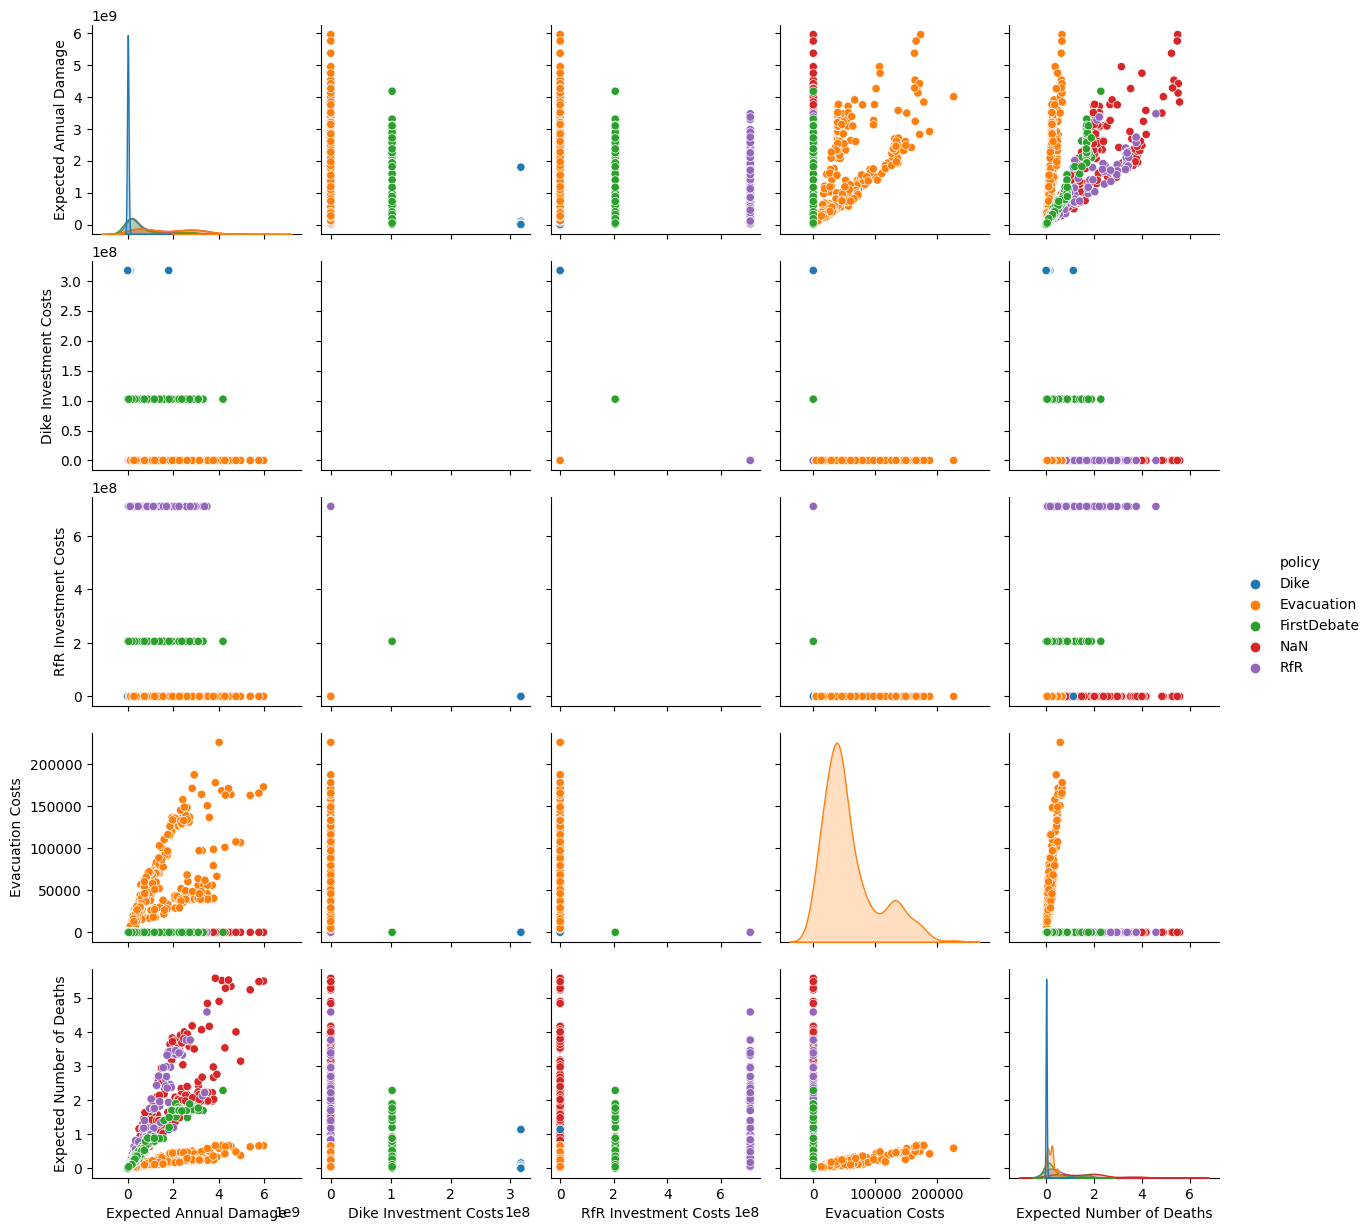

In [19]:
#Simple Visual Correlation and Trade-Off Analysis: for multiple outcomes of interest; Which uncertainties generate system behaviour?
#alternative seaborn sns based plot
experiments, outcomes = results
policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
plt.savefig('data/ox-pb2-outcome2outcome.png')
plt.show()

- evacuation limits reliably expected no. of deaths
- No measure risks high number of deaths
- only expected no. of deaths, evacuation costs and expected annual damage are sensitive to uncertainties
- evacuation can result in a large range of expected annual damage
- dike hightening results in lower expected annual damage

- A 'do nothing' policy would in the worst case (of 100 sampled uncertainty scenarios) cause 6 billion € in economic damage and 5 deaths per year (i.e. 135 deaths by 2050).
- A 'only RfR' policy would in the worst case (of 100 sampled uncertainty scenarios) cost 3.5 billion € total costs (damage + investment), of which 0.7 billion are investment costs, and 3 deaths per year (i.e. 81 deaths by 2050).
- A 'only Dike Raising' policy would in the worst case (of 100 sampled uncertainty scenarios) cost 3.9 billion € total costs (damage + investment), of which 0.2 billion are investment costs, and 2 deaths per year (i.e. more than 54 deaths by 2050).